In [2]:
import scipy.io as sio
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from numba import jit

from sklearn.decomposition import NMF

In [3]:
# #145 145 220
# def main():
#     # See https://rslab.ut.ac.ir/data for information about this dataset (Urban)
#     hs_image = sio.loadmat("data/Urban_R162.mat")
#     # print(type(hs_image))

#     # for key in hs_image:
#     #     print(key)

#     # Channels that are kept 
#     # print(hs_image["SlectBands"])

#     # Size of image 
#     # print(hs_image["nRow"])
#     # print(hs_image["nCol"])

#     # Number of wavelengths 
#     # print(hs_image["nBand"])

#     # Matrix itself 
#     # print(hs_image["Y"])

#     # Not sure what this mean 
#     # print(hs_image["maxValue"])

    
#     matrix = np.array(hs_image["Y"])

#     # Each row correspond to a channel/wavelength and the image is vectorized as a row vector (I am not sure how it is being flatten) 
#     # I am not sure what the value in the matrix mean. They range from 0 to 1000. I am guessing it is how much is captured by a particular channel after normalization  
#     print(matrix)

# main()

In [3]:
hs_image = sio.loadmat("data/Urban_R162.mat")
for key in hs_image:
    print(key)

print(hs_image["SlectBands"])

__header__
__version__
__globals__
SlectBands
nRow
nCol
nBand
Y
maxValue
[[  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [154]
 [155]
 [156]
 [157]
 [158]
 [159]
 [160]
 [161]
 [162]
 [163]
 [164]
 [165]
 [166]
 [167]
 [1

In [5]:
# for i in range(0,6):
#     fst_row = H[i]
#     fst_image = H[i].reshape((307, 307))

#     plt.imshow(fst_image, interpolation='nearest')
#     plt.show()

In [4]:
@jit(nopython=True, parallel=True)
def nmf_hs(X, delta, iters, components):
    (rows, cols) = X.shape
    A = np.random.rand(rows, components)
    S = np.random.rand(components, cols)
    all_delta_X = delta * np.ones((1, cols))
    all_delta_A = delta * np.ones((1, components))
    X_bar = np.vstack((X, all_delta_X))
    for _ in range(0, iters):
        A = A * (X @ np.transpose(S)) / (A @ S @ np.transpose(S))
        A_bar = np.vstack((A, all_delta_A))
        S = S * (np.transpose(A_bar) @ X_bar) / (np.transpose(A_bar) @ A_bar @ S)
        # print(np.linalg.norm(X - A @ S))
    error = (np.linalg.norm(X - A @ S))
    return A, S, error 

In [5]:
hs_image = sio.loadmat("data/Urban_R162.mat")
X = np.array(hs_image["Y"]).astype(np.float64)

W, H, error = nmf_hs(X, 1000.0, 1000, 6)
# error 

442888.33716237266
283008.1306008715
260943.0759548547
252152.75774364365
247347.20772289336
244198.49246729625
241868.99252596212
239973.6239911604
238290.7472565724
236657.72059037833
234922.4658740922
232913.94136824342
230420.0332216618
227172.11851725588
222844.0881869095
217082.6506682939
209590.07496894314
200264.47849375923
189350.71602724557
177491.89538860004
165586.63586255914
154498.58554338198
144800.28877468975
136693.6444350234
130091.9470173674
124757.70930227029
120413.81482406694
116804.83318583855
113719.96499865696
110995.34985914154
108508.10672397591
106168.4548992642
103912.51172735651
101696.50767073577
99492.37851345605
97284.4374206347
95066.80364774042
92841.32547737693
90615.81464549231
88402.47885728221
86216.4889828651
84074.6502001932
81994.16869320445
79991.5241318418
78081.47537944639
76276.23977204062
74584.88927086603
73012.995868461
71562.53493109738
70232.02506729444
69016.85554906519
67909.73497498017
66901.19154393517
65980.06534395316
65133.95258

In [6]:
np.ones((1, 6)) @ H

array([[0.99833449, 0.99860963, 0.99823682, ..., 0.99657096, 0.99620381,
        0.99634532]])

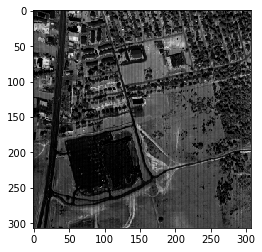

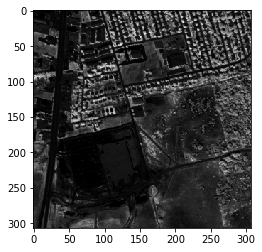

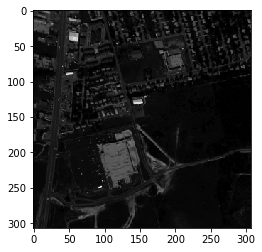

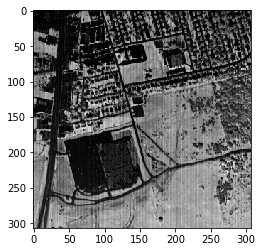

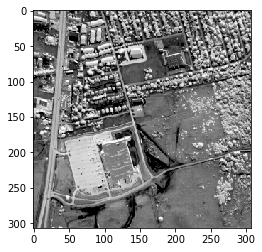

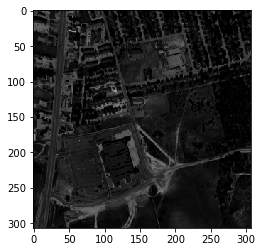

In [8]:
for i in range(0,6):
    fst_row = H[i]
    fst_image = H[i].reshape((307, 307))

    plt.imshow(fst_image, cmap='gray', interpolation='nearest')
    plt.show()

In [19]:
wavelength = hs_image["SlectBands"]

def radiation_expected(wavelength):
    return 3.8 * 10**8 / wavelength

def convertWToReflectivity(W):
    #https://github.com/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Article_Notebooks/Dimensionality_Reduction_on%C2%A0HSI_using_PCA.ipynb
    if(len(wavelength) != len(W)): return None
    newW = []

    for i in range(len(W)):
        newRow = []
        for j in range(len(W[i])):
            # val =( W[i][j] / radiation_expected(wavelength[i])) 
            val = W[i][j]/1000
            newRow += [val]
        newW += [newRow]

    newW = np.array(newW)
    print(newW.shape)
    return newW

def plot_endmembers(W, n_comps, title="Endmembers"):
    W_t = W.transpose()
    bands = range(162)
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.xlabel("Bands")
    plt.ylabel("Reflectance")
    plt.title(title)
    for i in range(n_comps):
        plt.plot(bands, W_t[i], color = colors[i])
    plt.show()

(162, 6)
(162, 6)
(162, 6)


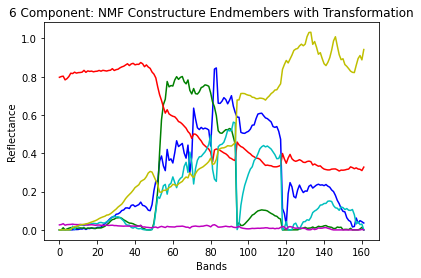

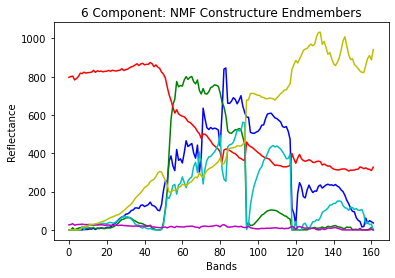

In [20]:
print(W.shape)

W_reflection = convertWToReflectivity(W)
# print(W_reflection)
print(W_reflection.shape)

plot_endmembers(W_reflection, 6, title="6 Component: NMF Constructure Endmembers with Transformation")
plot_endmembers(W, 6, title="6 Component: NMF Constructure Endmembers")



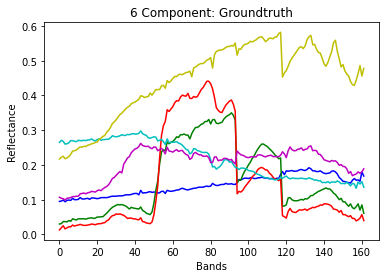

In [12]:
hs_image = sio.loadmat("data/groundTruth_Urban_end6/end6_groundTruth.mat")

W_gt6 = hs_image["M"]
plot_endmembers(W_gt6, 6, title="6 Component: Groundtruth")



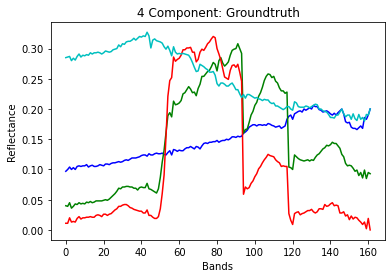

In [13]:
hs_image = sio.loadmat("data/groundTruth/end4_groundTruth.mat")

W_gt4 = hs_image["M"]
plot_endmembers(W_gt4, 4, title="4 Component: Groundtruth")
